## Подготовка датасета

На данном этапе производится загрузка и предварительная обработка датасетов для задачи детекции фишинговых email сообщений. Используются два датасета:
- **Nazario Phishing Corpus** (2015-2024) - датасет фишинговых писем
- **Enron Email Dataset** - датасет легитимных писем

Парсинг email, извлечение признаков и другие операции выполняются через модули системы (`src/email_parser.py`, `src/feature_extractor.py` и т.д.).




In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = (Path('/content/drive/MyDrive') / 'eml-phishing-analyzer').resolve()
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Настройка путей
DATA_RAW = BASE_DIR / 'data' / 'raw'
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'

# 1. Загрузка датасетов

## 1.1. Загрузка и сохранение Nazario Phishing Corpus

Отдельные файлы с письмами за период 2015-2024. Файлы в текстовом формате, письма начинаются с "From " и разделены пустой строкой.

In [ ]:
def split_nazario_file(file_path: Path) -> list:
    """
    Разделяет файл Nazario на отдельные email сообщения.

    Args:
        file_path: Путь к файлу

    Returns:
        list: Список строк с содержимым каждого email
    """
    emails = []
    current_email = []

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            if line.startswith('From ') and len(line) > 20 and '@' in line:
                if current_email:
                    emails.append(''.join(current_email))
                current_email = [line]
            else:
                current_email.append(line)

        if current_email:
            emails.append(''.join(current_email))

    return emails


# Загрузка Nazario Phishing Corpus (2015-2024)
nazario_path = DATA_RAW / 'nazario'
nazario_files = sorted(nazario_path.glob('phishing-*.txt'))

print(f"Найдено файлов Nazario: {len(nazario_files)}")

# Объединение всех файлов
all_nazario_emails = []
for file_path in tqdm(nazario_files, desc="Загрузка Nazario файлов"):
    emails = split_nazario_file(file_path)
    all_nazario_emails.extend(emails)

print(f"Всего загружено фишинговых писем: {len(all_nazario_emails)}")


Найдено файлов Nazario: 10


Загрузка Nazario файлов: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

Всего загружено фишинговых писем: 2978


Выведем несколько писем для проверки корректной обработки датасета.

In [ ]:
emails_nazario_example = all_nazario_emails[:5]
emails_nazario_example

["From MAILER-DAEMON Thu Sep 28 09:57:25 2017\nDate: 28 Sep 2017 09:57:25 -0400\nFrom: Mail System Internal Data <MAILER-DAEMON@monkey.org>\nSubject: DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA\nMessage-ID: <1506607045@monkey.org>\nX-IMAP: 1506607044 0000000307 $Forwarded\nStatus: RO\n\nThis text is part of the internal format of your mail folder, and is not\na real message.  It is created automatically by the mail system software.\nIf deleted, important folder data will be lost, and it will be re-created\nwith the data reset to initial values.\n\n",
 'From 125117@ihp-osb-lngweb5.ihp.iinet.net.au  Fri Jan  2 07:19:00 2015\nReturn-Path: <125117@ihp-osb-lngweb5.ihp.iinet.net.au>\nX-Original-To: jose@login.monkey.org\nDelivered-To: jose@login.monkey.org\nReceived: from forward.b.hostedemail.com (forward.b.hostedemail.com [64.98.36.17])\n\tby l.monkey.org (Postfix) with ESMTP id 180E6F4007\n\tfor <jose@login.monkey.org>; Fri,  2 Jan 2015 07:19:00 -0600 (CST)\nReceived: from smtpin10.

In [ ]:
# Сохранение в DataFrame для дальнейшей обработки
df_nazario = pd.DataFrame({
    'email_content': all_nazario_emails,
    'label': 1 # фишинговое письмо
})

In [ ]:
print(f"Размер датасета Nazario: {len(df_nazario)}")
print(f"Распределение меток: {df_nazario['label'].value_counts().to_dict()}")

Размер датасета Nazario: 2978
Распределение меток: {1: 2978}


In [ ]:
# Сохранение Nazario в CSV
nazario_csv_path = DATA_PROCESSED / 'nazario_raw.csv'
df_nazario.to_csv(nazario_csv_path, index=False)

## 1.2. Загрузка и сохранение Enron Email Dataset

Легитимные письма в формате CSV. После загрузки выполняется сравнение размеров с Nazario датасетом и балансировка при необходимости.


In [ ]:
# Определение структуры Enron файла
enron_path = DATA_RAW / 'enron' / 'emails.csv'

sample_df = pd.read_csv(enron_path).head()
print(f"Столбцы Enron: {sample_df.columns.tolist()}")

email_content_col = 'message'
print(f"Используется столбец: {email_content_col}")

Столбцы Enron: ['file', 'message']
Используется столбец: message


In [ ]:
# Загрузка Enron (по частям из-за большого размера)
chunk_size = 10000
enron_data = []

for chunk in tqdm(pd.read_csv(enron_path, chunksize=chunk_size), desc="Чтение Enron"):
    chunk_emails = chunk[[email_content_col]].copy()
    chunk_emails.columns = ['email_content']
    enron_data.append(chunk_emails)

df_enron_raw = pd.concat(enron_data, ignore_index=True)

print(f"Загружено легитимных писем: {len(df_enron_raw)}")

Чтение Enron: 52it [00:17,  2.99it/s]

Загружено легитимных писем: 517401


In [ ]:
# Уменьшение размера Enron до 2950 строк для балансировки
import random
target_size = 2950
print(f"Уменьшение размера Enron с {len(df_enron_raw)} до {target_size} строк...")
random.seed(42)
df_enron_raw = df_enron_raw.sample(n=target_size, random_state=42).reset_index(drop=True)
print(f"Размер после уменьшения: {len(df_enron_raw)}")

Уменьшение размера Enron с 517401 до 2950 строк...
Размер после уменьшения: 2950


In [ ]:
# Сохранение в DataFrame для дальнейшей обработки
df_enron = pd.DataFrame({
    'email_content': df_enron_raw['email_content'],
    'label': 0  # легитимное письмо
})

In [ ]:
df_enron.head()

,email_content,label
0,Message-ID: <21013688.1075844564560.JavaMail.e...,0
1,Message-ID: <22688499.1075854130303.JavaMail.e...,0
2,Message-ID: <27817771.1075841359502.JavaMail.e...,0
3,Message-ID: <10695160.1075858510449.JavaMail.e...,0
4,Message-ID: <27819143.1075853689038.JavaMail.e...,0


In [ ]:
print(f"Размер датасета Enron: {len(df_enron)}")
print(f"Распределение меток: {df_enron['label'].value_counts().to_dict()}")


Размер датасета Enron: 2950
Распределение меток: {0: 2950}


In [ ]:
# Сохранение Enron в CSV
enron_csv_path = DATA_PROCESSED / 'enron_raw.csv'
df_enron.to_csv(enron_csv_path, index=False)

## 1.3 Загрузка и сохранение test_emails
Загрузка тестовых писем из директории test_emails с автоматической разметкой по именам файлов.


In [ ]:
TEST_EMAILS_DIR = BASE_DIR / 'test_emails'
test_files = sorted(TEST_EMAILS_DIR.glob('*.eml'))

test_emails_content = []
test_emails_labels = []

for test_file in tqdm(test_files, desc="Загрузка test_emails"):
    with open(test_file, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    test_emails_content.append(content)
    label = 1 if 'phishing' in test_file.name.lower() else 0
    test_emails_labels.append(label)

df_test_emails = pd.DataFrame({
    'email_content': test_emails_content,
    'label': test_emails_labels
})

print(f"Загружено test_emails: {len(df_test_emails)}")
print(f"Распределение меток: {df_test_emails['label'].value_counts().to_dict()}")

Загрузка test_emails: 100%|██████████| 50/50 [00:00<00:00, 8676.31it/s]

Загружено test_emails: 50
Распределение меток: {0: 25, 1: 25}


In [ ]:
# Сохранение test_emails в CSV
test_emails_csv_path = DATA_PROCESSED / 'test_emails_raw.csv'
df_test_emails.to_csv(test_emails_csv_path, index=False)

# 2. Объединение датасетов и очистка данных

In [ ]:
import random
target_size = 2950
print(f"Уменьшение размера Nazario с {len(df_nazario)} до {target_size} строк...")
random.seed(42)
df_nazario = df_nazario.sample(n=target_size, random_state=42).reset_index(drop=True)
print(f"Размер после уменьшения: {len(df_enron_raw)}")

Уменьшение размера Nazario с 2978 до 2950 строк...
Размер после уменьшения: 2950


In [ ]:
# Объединение Nazario, Enron и test_emails в общий датафрейм
df = pd.concat([df_nazario, df_enron, df_test_emails], ignore_index=True)

## 2.1 Проверка и очистка данных

In [ ]:
# Подсчёт количества пустых значений и дублей до очистки
num_na = df['email_content'].isnull().sum()
num_dupes = df.duplicated().sum()
print(f"Пустых email_content: {num_na}")
print(f"Дубликатов: {num_dupes}")

# Очистка: удаляем пустые и дубликаты
df = df.dropna(subset=['email_content']).drop_duplicates().reset_index(drop=True)

print(f"Размер после очистки: {df.shape}")
print("\nФинальное распределение классов:")
print(df['label'].value_counts())

Пустых email_content: 0
Дубликатов: 0
Размер после очистки: (5950, 2)

Финальное распределение классов:
label
1    2975
0    2975
Name: count, dtype: int64


In [ ]:
df.head()

,email_content,label
0,From jose@monkey.org Thu Aug 17 11:41:23 2023 ...,1
1,From jose@monkey.org Fri Sep 27 15:46:37 2024 ...,1
2,From jose@monkey.org Mon Apr 20 11:26:14 2020 ...,1
3,From jose@monkey.org Thu Sep 21 19:14:02 2017 ...,1
4,From jose@monkey.org Wed May 3 17:20:00 2017 ...,1


In [ ]:
df.tail()

## 2.2. Сохранение итогового датасета

In [ ]:
# Сохранение итогового датасета
output_path = DATA_PROCESSED / 'email_dataset.csv'
df.to_csv(output_path, index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/eml-phishing-analyzer/data/processed/email_dataset.csv')

# 3. Парсинг email сообщений

Парсинг каждого email сообщения с использованием модуля `email_parser`.
Извлекаются заголовки, тело письма, вложения, URL и домены.


In [13]:
!pip install tldextract urlextract langdetect argostranslate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.3 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=0822de3de24f60ba1d64aae9b25fe0862b98bff5059911833171368e3b873e15
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
from src.email_parser import parse_email
from src.translation import Translator
from src.url_domain_analyzer import analyze_urls_and_domains
from src.feature_extractor import FeatureExtractor

import pickle
from sklearn.model_selection import train_test_split

# Инициализация компонентов
translator = Translator()

In [ ]:
# Парсинг всех email сообщений
parsed_emails = []
invalid_indices = []
initial_count = len(df)

for idx, email_content in tqdm(enumerate(df['email_content']), total=len(df), desc="Парсинг писем"):
    try:
        parsed = parse_email(str(email_content))
        parsed_emails.append(parsed)
    except Exception as e:
        invalid_indices.append(idx)
        print(f"Ошибка парсинга письма {idx}: {str(e)[:100]}... Письмо будет удалено из датасета\n")

if invalid_indices:
    df = df.drop(df.index[invalid_indices]).reset_index(drop=True)

print(f"Обработано писем: {len(parsed_emails)}")
print(f"Удалено писем с ошибками: {len(invalid_indices)} ({len(invalid_indices)/initial_count*100:.2f}%)")


Парсинг писем:   6%|▋         | 376/5950 [00:09<02:08, 43.39it/s]

Ошибка парсинга письма 371: unknown encoding: utf-8return-path: bounce-810_html-769869545-477063-1070564-43@bounce.email.oflce57... Письмо будет удалено из датасета



Парсинг писем:  11%|█         | 645/5950 [00:16<01:45, 50.50it/s]

Ошибка парсинга письма 638: unknown encoding: utf-8message-id: <1571316602-94a08da1fecbb6e8b46990538c7b50b2-94a08da1fecbb6e8b469... Письмо будет удалено из датасета



Парсинг писем:  19%|█▊        | 1108/5950 [00:27<01:37, 49.58it/s]

Ошибка парсинга письма 1100: unknown encoding: utf-8return-path: bounce-810_html-769869545-477063-1070564-43@bounce.email.oflce57... Письмо будет удалено из датасета



Парсинг писем:  41%|████      | 2418/5950 [01:18<01:52, 31.49it/s]

Ошибка парсинга письма 2414: unknown encoding: utf-8return-path: bounce-810_html-769869545-477063-1070564-43@bounce.email.oflce57... Письмо будет удалено из датасета



Парсинг писем:  41%|████      | 2448/5950 [01:19<01:46, 32.93it/s]

Ошибка парсинга письма 2444: unknown encoding: utf-8x-priority: 3... Письмо будет удалено из датасета



Парсинг писем: 100%|██████████| 5950/5950 [02:36<00:00, 37.98it/s]

Обработано писем: 5945
Удалено писем с ошибками: 5 (0.08%)


In [ ]:
output_path = DATA_PROCESSED / 'email_dataset.csv'
df.to_csv(output_path, index=False)

# 4. Перевод текста писем

Перевод русскоязычных писем на английский язык для единообразной обработки.


In [ ]:
# Перевод всех писем
translated_texts = []
translated_count = 0

prepare_text_func = FeatureExtractor.prepare_text_from_parsed_email

for parsed_email in tqdm(parsed_emails, desc="Перевод писем"):
    try:
        clean_text = prepare_text_func(parsed_email)
        detected_language = translator.detect_language(clean_text) if clean_text else 'en'
        translated = translator.translate_text(clean_text)
        if detected_language == 'ru':
            translated_count += 1
        translated_texts.append(translated)
    except Exception as e:
        print(f"Ошибка перевода: {e}")
        subject = parsed_email.get('subject', '') or ''
        body = parsed_email.get('body_plain', '') or ''
        if not body:
            body = parsed_email.get('body_html', '') or ''
        translated_texts.append(f"{subject} {body}".strip())

print(f"Обработано писем: {len(translated_texts)}")
print(f"Переведено с русского на английский: {translated_count}")
print(f"Писем на английском: {len(translated_texts) - translated_count}")


Перевод писем: 100%|██████████| 5945/5945 [07:33<00:00, 13.11it/s]

Обработано писем: 5945
Переведено с русского на английский: 42
Писем на английском: 5903


# 5. Анализ URL и доменов

Анализ URL-адресов и доменов для выявления подозрительных паттернов: URL-shorteners, длинные домены, подозрительные TLD, IP-адреса в URL.


In [ ]:
# Анализ URL и доменов для каждого письма
url_analyses = []

for parsed_email in tqdm(parsed_emails, desc="Анализ URL/доменов"):
    try:
        analysis = analyze_urls_and_domains(parsed_email)
        url_analyses.append(analysis)
    except Exception as e:
        print(f"Ошибка анализа URL/доменов: {e}")
        url_analyses.append({
            'has_url_shortener': False,
            'has_long_domain': False,
            'has_suspicious_tld': False,
            'has_ip_in_url': False
        })

print(f"Обработано: {len(url_analyses)}")


Анализ URL/доменов: 100%|██████████| 5945/5945 [00:00<00:00, 11924.78it/s]

Обработано: 5945


# 6. Извлечение признаков

Этап включает:
1. Проверка балансировки классов в датасете
2. Разделение данных на train/validation/test с сохранением пропорций классов
3. Обучение TF-IDF векторизатора на обучающей выборке
4. Обучение MinMaxScaler на синтетических признаках из обучающей выборки
5. Создание финальных feature vectors для всех выборок (TF-IDF + синтетические признаки)
6. Проверка признаков на data leakage и переобучение

## 6.1 Проверка балансировки классов

Проверка соотношения legitimate/phishing классов в датасете.


In [3]:
# Создание директории для сохранения
MODELS_DIR = BASE_DIR / 'data' / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

Распределение классов:
  Legitimate (0): 2975 (50.04%)
  Phishing (1): 2970 (49.96%)


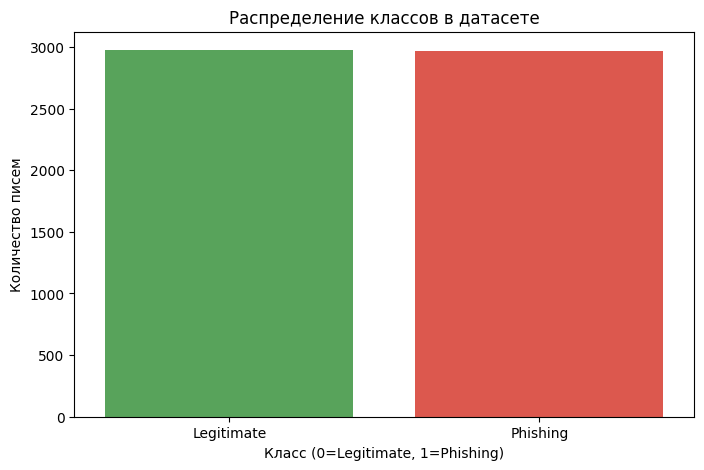


Классы сбалансированы


In [ ]:
# Проверка балансировки классов
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['label'].value_counts()
class_percentages = df['label'].value_counts(normalize=True) * 100

print("Распределение классов:")
print(f"  Legitimate (0): {class_counts.get(0, 0)} ({class_percentages.get(0, 0):.2f}%)")
print(f"  Phishing (1): {class_counts.get(1, 0)} ({class_percentages.get(1, 0):.2f}%)")

# Визуализация
plt.figure(figsize=(8, 5))
sns.countplot(x=df['label'], palette=['#4CAF50', '#F44336'])
plt.title('Распределение классов в датасете')
plt.xlabel('Класс (0=Legitimate, 1=Phishing)')
plt.ylabel('Количество писем')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.show()

# Проверка балансировки
if abs(class_percentages.get(0, 0) - class_percentages.get(1, 0)) > 5:
    print("\nКлассы несбалансированы")
else:
    print("\nКлассы сбалансированы")


## 6.2 Разделение данных на train/validation/test

Разделение датасета на три части:
- **70%** train — для обучения моделей
- **15%** validation — для подбора гиперпараметров
- **15%** test — для финальной оценки

Используется стратифицированное разделение для сохранения пропорций классов.

In [ ]:
# Разделение данных на train/validation/test
indices = np.arange(len(df))
train_indices, temp_indices = train_test_split(
    indices, test_size=0.3, stratify=df['label'].values, random_state=42
)
val_indices, test_indices = train_test_split(
    temp_indices, test_size=0.5,
    stratify=df.iloc[temp_indices]['label'].values, random_state=42
)

y_train = df.iloc[train_indices]['label'].values
y_val = df.iloc[val_indices]['label'].values
y_test = df.iloc[test_indices]['label'].values

train_translated_texts = [translated_texts[idx] for idx in train_indices]
val_translated_texts = [translated_texts[idx] for idx in val_indices]
test_translated_texts = [translated_texts[idx] for idx in test_indices]

print(f"Разделение индексов завершено:")
print(f"  Train:      {len(train_indices)} образцов ({len(train_indices)/len(df)*100:.1f}%)")
print(f"  Validation: {len(val_indices)} образцов ({len(val_indices)/len(df)*100:.1f}%)")
print(f"  Test:       {len(test_indices)} образцов ({len(test_indices)/len(df)*100:.1f}%)")

print(f"\nРаспределение классов в train:")
print(f"  Legitimate: {np.sum(df.iloc[train_indices]['label'] == 0)} ({np.sum(df.iloc[train_indices]['label'] == 0)/len(train_indices)*100:.1f}%)")
print(f"  Phishing:   {np.sum(df.iloc[train_indices]['label'] == 1)} ({np.sum(df.iloc[train_indices]['label'] == 1)/len(train_indices)*100:.1f}%)")

print(f"\nРаспределение классов в validation:")
print(f"  Legitimate: {np.sum(df.iloc[val_indices]['label'] == 0)} ({np.sum(df.iloc[val_indices]['label'] == 0)/len(val_indices)*100:.1f}%)")
print(f"  Phishing:   {np.sum(df.iloc[val_indices]['label'] == 1)} ({np.sum(df.iloc[val_indices]['label'] == 1)/len(val_indices)*100:.1f}%)")

print(f"\nРаспределение классов в test:")
print(f"  Legitimate: {np.sum(df.iloc[test_indices]['label'] == 0)} ({np.sum(df.iloc[test_indices]['label'] == 0)/len(test_indices)*100:.1f}%)")
print(f"  Phishing:   {np.sum(df.iloc[test_indices]['label'] == 1)} ({np.sum(df.iloc[test_indices]['label'] == 1)/len(test_indices)*100:.1f}%)")


Разделение индексов завершено:
  Train:      4161 образцов (70.0%)
  Validation: 892 образцов (15.0%)
  Test:       892 образцов (15.0%)

Распределение классов в train:
  Legitimate: 2082 (50.0%)
  Phishing:   2079 (50.0%)

Распределение классов в validation:
  Legitimate: 446 (50.0%)
  Phishing:   446 (50.0%)

Распределение классов в test:
  Legitimate: 447 (50.1%)
  Phishing:   445 (49.9%)


## 6.3 Подбор оптимальных параметров TF-IDF векторизатора

 На этом этапе проводится автоматизированный поиск лучших параметров для TF-IDF векторизатора

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import uniform, randint
import time

In [ ]:
temp_feature_extractor = FeatureExtractor(max_features=3000)

preprocessed_train = [temp_feature_extractor.preprocess_text(text) for text in train_translated_texts]
preprocessed_val = [temp_feature_extractor.preprocess_text(text) for text in val_translated_texts]

In [ ]:
# Создание pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        strip_accents='unicode',
        token_pattern=r'\b[a-z]{3,}\b',
        stop_words='english',
        use_idf=True,
        smooth_idf=True
    )),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_distributions = {
    'tfidf__max_features': randint(1500, 5000),
    'tfidf__max_df': uniform(0.1, 0.4),
    'tfidf__min_df': randint(1, 15),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'classifier__n_estimators': [100],
    'classifier__max_depth': [8, 10]
}

# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions,
    n_iter=50,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42,
    return_train_score=True
)

start_time = time.time()
random_search.fit(train_translated_texts, y_train)
elapsed_time = time.time() - start_time

print(f"\n{'=' * 80}")
print(f"Поиск завершен за {elapsed_time / 60:.1f} минут")
print(f"{'=' * 80}")

# Результаты
print("\nЛучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print("\nМетрики:")
print(f"  Лучший F1-score (5-fold CV): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Поиск завершен за 18.4 минут

Лучшие параметры:
  classifier__max_depth: 8
  classifier__n_estimators: 100
  tfidf__max_df: 0.20351199264000677
  tfidf__max_features: 4959
  tfidf__min_df: 2
  tfidf__ngram_range: (1, 2)
  tfidf__norm: l2
  tfidf__sublinear_tf: False

Метрики:
  Лучший F1-score (5-fold CV): 0.9576


## 6.4 Применение оптимальных параметров TF-IDF

Применение найденных оптимальных параметров к FeatureExtractor перед обучением векторизатора.


In [ ]:
# Извлечение и применение оптимальных параметров TF-IDF
optimal_tfidf_params = {
    param.replace('tfidf__', ''): value
    for param, value in random_search.best_params_.items()
    if param.startswith('tfidf__')
}

print("Оптимальные параметры TF-IDF:")
for param, value in optimal_tfidf_params.items():
    print(f"  {param}: {value}")

max_features = optimal_tfidf_params.get('max_features', 3000)
feature_extractor = FeatureExtractor(max_features=max_features)

# Обновление векторизатора с оптимальными параметрами
feature_extractor.tfidf_vectorizer.set_params(
    max_features=max_features,
    max_df=optimal_tfidf_params.get('max_df', 0.3),
    min_df=optimal_tfidf_params.get('min_df', 3),
    ngram_range=optimal_tfidf_params.get('ngram_range', (1, 2)),
    sublinear_tf=optimal_tfidf_params.get('sublinear_tf', True),
    norm=optimal_tfidf_params.get('norm', 'l2')
)

# Сохранение параметров
with open(MODELS_DIR / 'optimal_tfidf_params.pkl', 'wb') as f:
    pickle.dump(optimal_tfidf_params, f)

print("\nПараметры применены к FeatureExtractor и сохранены")

Оптимальные параметры TF-IDF:
  max_df: 0.20351199264000677
  max_features: 4959
  min_df: 2
  ngram_range: (1, 2)
  norm: l2
  sublinear_tf: False

Параметры применены к FeatureExtractor и сохранены


## 6.5 Обучение TF-IDF векторизатора на обучающей выборке

Обучение TF-IDF векторизатора с примененными оптимальными параметрами на текстах обучающей выборки.


In [ ]:
# Обучение TF-IDF векторизатора на обучающей выборке
feature_extractor.fit_vectorizer(train_translated_texts)
print(f"TF-IDF векторизатор обучен. Размер словаря: {len(feature_extractor.tfidf_vectorizer.vocabulary_)}")

TF-IDF векторизатор обучен. Размер словаря: 4959


## 6.6 Обучение MinMaxScaler на обучающей выборке

Обучение MinMaxScaler на синтетических признаках из обучающей выборки для нормализации данных.


In [ ]:
train_synthetic_features_list = []
feature_size = None

df_indices = df.index.to_list()
idx_to_pos = {idx: pos for pos, idx in enumerate(df_indices)}

for idx in tqdm(train_indices, desc="Извлечение синтетических признаков"):
    try:
        pos = idx_to_pos[idx]
        parsed_email = parsed_emails[pos]
        translated_text = translated_texts[pos]
        url_analysis = url_analyses[pos]

        quantitative = feature_extractor.extract_quantitative_features(parsed_email)
        structural = feature_extractor.extract_structural_features(parsed_email)
        binary = feature_extractor.extract_binary_indicators(url_analysis, parsed_email)
        linguistic = feature_extractor.extract_linguistic_features(translated_text)

        synthetic_features_array = np.concatenate([
            quantitative,
            structural,
            binary,
            linguistic
        ])

        if feature_size is None:
            feature_size = len(synthetic_features_array)

        train_synthetic_features_list.append(synthetic_features_array)
    except Exception as e:
        if feature_size is None:
            feature_size = 10
        train_synthetic_features_list.append(np.zeros(feature_size, dtype=np.float32))

feature_extractor.fit_scaler(train_synthetic_features_list)
print(f"MinMaxScaler обучен. Размерность синтетических признаков: {feature_size}")

Извлечение синтетических признаков: 100%|██████████| 4161/4161 [00:05<00:00, 810.38it/s]

MinMaxScaler обучен. Размерность синтетических признаков: 10


## 6.7 Создание финальных feature vectors

Создание финальных feature vectors путем объединения TF-IDF векторов и нормализованных синтетических признаков.

In [ ]:
# Создание финальных feature vectors (TF-IDF + нормализованные синтетические признаки)
X_features = []
y_labels = []

tfidf_dim = len(feature_extractor.tfidf_vectorizer.vocabulary_)
feature_dim = tfidf_dim + 10

for idx in tqdm(range(len(df)), desc="Создание feature vectors"):
    try:
        parsed_email = parsed_emails[idx]
        translated_text = translated_texts[idx]
        url_analysis = url_analyses[idx]

        # extract_all_features использует обученный TF-IDF векторизатор и MinMaxScaler
        features = feature_extractor.extract_all_features(
            parsed_email,
            translated_text,
            url_analysis
        )
        X_features.append(features['feature_vector'])
        y_labels.append(df.iloc[idx]['label'])
    except Exception as e:
        print(f"Ошибка создания feature vector для письма {idx}: {e}")
        X_features.append(np.zeros(feature_dim, dtype=np.float32))
        y_labels.append(df.iloc[idx]['label'])

# Преобразование в numpy массивы
X = np.array(X_features)
y = np.array(y_labels)

print(f"\n Feature vectors созданы:")
print(f"  Размерность X: {X.shape}")
print(f"  Размерность y: {y.shape}")
print(f"  Распределение классов: {np.bincount(y)}")

Создание feature vectors: 100%|██████████| 5945/5945 [00:36<00:00, 164.05it/s]



 Feature vectors созданы:
  Размерность X: (5945, 4969)
  Размерность y: (5945,)
  Распределение классов: [2975 2970]


In [ ]:
# Сохранение метаданных о признаках для консистентности на инференсе
import json

tfidf_dim = len(feature_extractor.tfidf_vectorizer.vocabulary_)
total_dim = X.shape[1]
synthetic_dim = total_dim - tfidf_dim

concat_order = "tfidf_then_synthetic"

# Имена синтетических признаков в правильном порядке
synthetic_feature_names = [
    "url_count",
    "attachment_count",
    "ip_count",
    "subject_length",
    "body_length",
    "has_url_shortener",
    "has_long_domain",
    "has_suspicious_tld",
    "has_ip_in_url",
    "urgency_markers_count"
]

feature_meta = {
    "tfidf_dim": tfidf_dim,
    "synthetic_dim": synthetic_dim,
    "total_dim": total_dim,
    "concat_order": concat_order,
    "synthetic_feature_names": synthetic_feature_names,
    "dtype": "float32"
}

# Сохранение метаданных
with open(MODELS_DIR / 'feature_meta.json', 'w', encoding='utf-8') as f:
    json.dump(feature_meta, f, ensure_ascii=False, indent=2)

print(f"\n Метаданные признаков сохранены:")
print(f"  TF-IDF размерность: {tfidf_dim}")
print(f"  Синтетические признаки: {synthetic_dim}")
print(f"  Общая размерность: {total_dim}")
print(f"  Порядок склейки: {concat_order}")


 Метаданные признаков сохранены:
  TF-IDF размерность: 4959
  Синтетические признаки: 10
  Общая размерность: 4969
  Порядок склейки: tfidf_then_synthetic


In [ ]:
train_indices = np.array(train_indices, dtype=int)
val_indices = np.array(val_indices, dtype=int)
test_indices = np.array(test_indices, dtype=int)

X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

print(f"\nРазделение данных применено:")
print(f"  Train:      {X_train.shape[0]} образцов ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]} образцов ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]} образцов ({X_test.shape[0]/len(X)*100:.1f}%)")


Разделение данных применено:
  Train:      4161 образцов (70.0%)
  Validation: 892 образцов (15.0%)
  Test:       892 образцов (15.0%)


# 7. Проверка на data leakage

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from scipy.sparse import issparse

if issparse(X_train):
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
else:
    X_train_dense = X_train
    X_val_dense = X_val

model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train_dense, y_train)

train_f1 = f1_score(y_train, model.predict(X_train_dense))
val_f1 = f1_score(y_val, model.predict(X_val_dense))

print(f"Train F1: {train_f1:.3f}")
print(f"Validation F1: {val_f1:.3f}")
print(f"Разница: {train_f1 - val_f1:.3f}")

if train_f1 - val_f1 > 0.10:
    print("Обнаружено переобучение")
else:
    print("Переобучение минимально")

Train F1: 0.985
Validation F1: 0.971
Разница: 0.014
Переобучение минимально


# 8. Сохранение обработанных данных

Сохранение разделенных данных (train/validation/test) и обученного TF-IDF векторизатора с MinMaxScaler в pickle файлы для использования при обучении моделей в `model_training.ipynb`.


In [ ]:
# Сохранение train/validation/test данных в sparse формате
from scipy.sparse import csr_matrix, issparse

# Преобразование в sparse формат
if not issparse(X_train):
    X_train = csr_matrix(X_train)
if not issparse(X_val):
    X_val = csr_matrix(X_val)
if not issparse(X_test):
    X_test = csr_matrix(X_test)

with open(MODELS_DIR / 'train.pkl', 'wb') as f:
    pickle.dump({
        'X_train': X_train,
        'y_train': y_train,
        'train_indices': train_indices
    }, f)
print(f" train.pkl сохранен")

with open(MODELS_DIR / 'val.pkl', 'wb') as f:
    pickle.dump({
        'X_val': X_val,
        'y_val': y_val,
        'val_indices': val_indices
    }, f)
print(f" val.pkl сохранен")

with open(MODELS_DIR / 'test.pkl', 'wb') as f:
    pickle.dump({
        'X_test': X_test,
        'y_test': y_test,
        'test_indices': test_indices
    }, f)
print(f" test.pkl сохранен:")

# Сохранение обученного TF-IDF векторизатора и MinMaxScaler
feature_extractor.save_vectorizer(str(MODELS_DIR / 'tfidf_vectorizer.pkl'))
print(f" tfidf_vectorizer.pkl сохранен (включает TF-IDF векторизатор и MinMaxScaler)")

 train.pkl сохранен
 val.pkl сохранен
 test.pkl сохранен:
 tfidf_vectorizer.pkl сохранен (включает TF-IDF векторизатор и MinMaxScaler)


----------------------------

In [23]:
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

from src.email_parser import parse_email
from src.translation import Translator
from src.url_domain_analyzer import analyze_urls_and_domains
from src.feature_extractor import FeatureExtractor

In [32]:
from src.email_parser import parse_email
from src.header_analyzer import analyze_headers
from src.rules_engine import evaluate_all_rules
from src.threat_intelligence import ThreatIntelligence

In [24]:
# Пути
BASE_DIR = (Path('/content/drive/MyDrive') / 'eml-phishing-analyzer').resolve()
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))
DATA_PROCESSED = BASE_DIR / 'data' / 'processed'
MODELS_DIR = BASE_DIR / 'data' / 'models'

test_csv_path = DATA_PROCESSED / 'test_emails_raw.csv'
model_path = MODELS_DIR / 'logreg.pkl'
weights_path = MODELS_DIR / 'optimal_weights.json'
vectorizer_path = MODELS_DIR / 'tfidf_vectorizer.pkl'


In [25]:
# Загрузка данных
df_test = pd.read_csv(test_csv_path)

with open(model_path, "rb") as f:
    logreg_model = pickle.load(f)

with open(weights_path, "r", encoding="utf-8") as f:
    opt = json.load(f)

w_rules = float(opt["w_rules"])
w_ml = float(opt["w_ml"])
threshold = float(opt["threshold"])

In [27]:
# Инициализация модулей
translator = Translator()

feature_extractor = FeatureExtractor(max_features=3000)
feature_extractor.load_vectorizer(str(vectorizer_path))

In [31]:
from src.threat_intelligence import ThreatIntelligence

ti_path = BASE_DIR / 'data' / 'threat_intelligence' / 'ti_test_real_feeds.db'


# TI и эвристика (как у вас)
ti = ThreatIntelligence(ti_path)

def compute_risk_score(email_content: str) -> int:
    try:
        parsed = parse_email(email_content)
        header_analysis = analyze_headers(parsed)
        ti_results = ti.check_reputation(parsed.get('domains', []), parsed.get('ips', []))
        return evaluate_all_rules(header_analysis, parsed, ti_results)['risk_score']
    except:
        return 0

In [33]:
prepare_text = FeatureExtractor.prepare_text_from_parsed_email

# Проверка test_emails
rows = []

In [34]:
for i, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Проверка test_emails"):
    email_content = str(row["email_content"])
    true_label = int(row["label"]) if "label" in df_test.columns else None

    parsed = parse_email(email_content)

    clean_text = prepare_text(parsed)
    detected_language = translator.detect_language(clean_text) if clean_text else "en"
    translated_text = translator.translate_text(clean_text) if detected_language == "ru" else clean_text

    url_analysis = analyze_urls_and_domains(parsed)

    feats = feature_extractor.extract_all_features(parsed, translated_text, url_analysis)
    x = feats["feature_vector"].reshape(1, -1)

    ml_conf = float(logreg_model.predict_proba(x)[:, 1][0])

    risk_score = float(compute_risk_score(email_content))  # 0..100
    risk_norm = risk_score / 100.0

    final_score = w_rules * risk_norm + w_ml * ml_conf
    pred_label = int(final_score >= threshold)

    subject = (parsed.get("subject") or "")[:120]

    rows.append({
        "idx": i,
        "subject": subject,
        "true_label": true_label,
        "pred_label": pred_label,
        "risk_score": round(risk_score, 3),
        "risk_norm": round(risk_norm, 3),
        "ml_conf": round(ml_conf, 3),
        "final_score": round(final_score, 3),
        "threshold": round(threshold, 3),
        "w_rules": round(w_rules, 2),
        "w_ml": round(w_ml, 2),
    })

Проверка test_emails: 100%|██████████| 50/50 [04:41<00:00,  5.62s/it]


In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

if results_df["true_label"].notna().all():
    y_true = results_df["true_label"].astype(int).values
    y_pred = results_df["pred_label"].astype(int).values

    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-score:  {f1_score(y_true, y_pred):.4f}")

Accuracy:  0.9400
Precision: 0.8929
Recall:    1.0000
F1-score:  0.9434


In [38]:
display(results_df)

,idx,subject,true_label,pred_label,risk_score,risk_norm,ml_conf,final_score,threshold,w_rules,w_ml
0,0,"AI Agents, Red Teaming, and a Smarter AI Tutor",0,0,30.0,0.3,0.010,0.097,0.5,0.3,0.7
1,1,Labor Day Sale: Unlock Forbes for Just $49.99/...,0,1,30.0,0.3,0.857,0.690,0.5,0.3,0.7
2,2,500 баллов Плюса от Яндекс Еды,0,1,100.0,1.0,1.000,1.000,0.5,0.3,0.7
3,3,Обновление Условий обслуживания и Политики кон...,0,0,0.0,0.0,0.020,0.014,0.5,0.3,0.7
4,4,Solve the problem of the day to stay on track,0,0,0.0,0.0,0.010,0.007,0.5,0.3,0.7
5,5,Выписка по счёту за декабрь 2024,0,0,0.0,0.0,0.030,0.021,0.5,0.3,0.7
6,6,Ваш заказ №987654 оформлен,0,0,0.0,0.0,0.021,0.015,0.5,0.3,0.7
7,7,Напоминание о совещании 19.12.2024,0,0,0.0,0.0,0.000,0.000,0.5,0.3,0.7
8,8,РБК: главные новости дня – 17 декабря,0,0,0.0,0.0,0.000,0.000,0.5,0.3,0.7
9,9,Уведомление о готовности документа,0,0,0.0,0.0,0.015,0.010,0.5,0.3,0.7


In [37]:
def show_triggered_rules(email_idx: int):
    row = results_df.loc[results_df["idx"] == email_idx].iloc[0]
    email_content = str(df_test.loc[email_idx, "email_content"])

    parsed = parse_email(email_content)
    header_analysis = analyze_headers(parsed)
    ti_results = ti.check_reputation(parsed.get('domains', []), parsed.get('ips', []))
    rules_result = evaluate_all_rules(header_analysis, parsed, ti_results)

    rule_details = rules_result.get("rule_details", [])
    triggered_rules = rules_result.get("triggered_rules", [])

    if isinstance(rule_details, dict):
        rule_details = [rule_details]

    # Если rule_details пустой, но есть triggered_rules — выведем хотя бы их
    if not rule_details and triggered_rules:
        rule_details = [{"rule_id": r} for r in triggered_rules]

    rules_df = pd.DataFrame(rule_details)

    # Если есть поле с флагом срабатывания — фильтруем по нему
    trigger_cols = [c for c in ["triggered", "is_triggered", "matched", "fired"] if c in rules_df.columns]
    if trigger_cols:
        rules_df = rules_df[rules_df[trigger_cols[0]] == True]

    if len(rules_df) == 0:
        print(f"Для письма idx={email_idx} сработавших правил не найдено.")
        return

    display(rules_df)

In [44]:
idx = 13

row = df_test.loc[idx]

print(f"Index: {idx}")
print(f"Label: {row.get('label', 'N/A')}")
print(f"Subject:\n{row.get('subject', '')}")
print("\nEmail content:\n")
print(row.get('email_content', ''))


Index: 13
Label: 0
Subject:


Email content:

Content-Type: multipart/alternative; boundary="===============4507339361867880623=="
MIME-Version: 1.0
Subject: =?utf-8?b?0J3QvtCy0L7QtSDRgdC+0L7QsdGJ0LXQvdC40LUg0LIg0LvQuNGH0L3Ri9GFINGB0L7QvtCx0YnQtdC90LjRj9GF?=
From: =?utf-8?b?0JLQmtC+0L3RgtCw0LrRgtC1IDxub3JlcGx5QHZrLmNvbT4=?=
To: customer@example.ru
Date: Tue, 30 Dec 2025 12:23:46 +0300
Message-ID: <05aa5b0e2b816189.1767086626@vk.com>
Authentication-Results: mx.google.com; spf=pass smtp.mailfrom=vk.com; dkim=pass header.i=@vk.com; dmarc=pass header.from=vk.com
Received: from mail.vk.com (87.240.132.72) by mx.google.com with ESMTPS id 05aa5b0e2b; Tue, 30 Dec 2025 12:23:46 +0300
Return-Path: <noreply@vk.com>

--===============4507339361867880623==
Content-Type: text/plain; charset="utf-8"
MIME-Version: 1.0
Content-Transfer-Encoding: base64

0J/RgNC40LLQtdGCIQoK0KMg0LLQsNGBINC90L7QstC+0LUg0YHQvtC+0LHRidC10L3QuNC1INC+
0YIg0L/QvtC70YzQt9C+0LLQsNGC0LXQu9GPINCQ0L3QvdCwINCf0LXRgtGA0L7QstCwLgoK0J

In [41]:
show_triggered_rules(13)

,authentication,domain_mismatch,reply_anomaly,threat_intelligence,dangerous_attachments
0,"{'triggered': False, 'score': 0, 'details': 'A...","{'triggered': False, 'score': 0, 'details': 'A...","{'triggered': False, 'score': 0, 'details': 'N...","{'triggered': False, 'score': 0, 'details': 'N...","{'triggered': False, 'score': 0, 'details': 'N..."
